# Ray Tune on Hyperplane demo

### install and update libraries
- this can be skipped when ray is fully integrated

In [1]:
# !pip install tensorboardX --quiet


In [2]:
import pandas as pd
import ray
print(f'ray version {ray.__version__}')
print(f'pandas version {pd.__version__}')

ray version 1.8.0
pandas version 1.2.3


### initialize ray cluster with remote cluster

In [3]:
from hyperplane.ray_common import initialize_ray_cluster, stop_ray_cluster, find_ray_workers
num_workers = 2
cpu_core_per_worker = 15
ram_gb_per_worker = 12 #110 GB allocatible for 16_128 nodes, 12 for 16_16 nodes, 27 for 32_32 nodes
ray_cluster = initialize_ray_cluster(num_workers, cpu_core_per_worker, ram_gb_per_worker)

deleting pod ray-worker-77eb2548-bc5f-43bd-9c1a-4ff59fb03b26
deleting pod ray-worker-e3fc8c5b-84c0-41b9-ba23-149d722384be
👉 Hyperplane: selecting worker node pool
best pool spec {'pool_env_var': 'DASK_POOL_16_16', 'allocatable_cores': 15.0, 'allocatable_ram': 12.0}


2021-12-08 15:10:53,795	INFO services.py:1270 -- View the Ray dashboard at http://127.0.0.1:8265
2021-12-08 15:10:53,799	WARNING services.py:1748 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=8.51gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


Waiting for worker ray-worker-b629b041-9f6c-49c3-bb7c-4f338b0d49b9...
Waiting for worker ray-worker-cee4eb89-6773-4c15-9e80-35b79ae5a181...


## example 1 - basic

In [7]:
from ray import tune

In [8]:
def objective(step, alpha, beta):
    return (0.1 + alpha * step / 100)**(-1) + beta * 0.1


def training_function(config,  checkpoint_dir=None):
    # Hyperparameters
    alpha, beta = config["alpha"], config["beta"]
    for step in range(10):
        # Iterative training function - can be any arbitrary training procedure.
        intermediate_score = objective(step, alpha, beta)
        # Feed the score back back to Tune.
        tune.report(mean_loss=intermediate_score)


analysis = tune.run(
    training_function,
    config={
        "alpha": tune.grid_search([0.001, 0.01, 0.1]),
        "beta": tune.choice([1, 2, 3])
    },
#     sync_config=tune.SyncConfig(
#         sync_to_driver=False,
#         upload_dir="gs://pipeline_data/ray_data"
#     ),
    verbose = 1
)

print("Best config: ", analysis.get_best_config(
    metric="mean_loss", mode="min"))

# Get a dataframe for analyzing trial results.
df = analysis.results_df

2021-12-08 15:19:00,531	INFO tune.py:630 -- Total run time: 1.39 seconds (1.26 seconds for the tuning loop).


Best config:  {'alpha': 0.1, 'beta': 1}


In [9]:
df

,mean_loss,time_this_iter_s,done,timesteps_total,episodes_total,training_iteration,neg_mean_loss,experiment_id,date,timestamp,time_total_s,pid,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,experiment_tag,config.alpha,config.beta
trial_id,,,,,,,,,,,,,,,,,,,,
2ad3d_00000,10.191008,0.005508,True,None,None,10,-10.191008,af590b6141e54d738fa90c137ee16b22,2021-12-08_15-18-59,1638976739,0.044360,67,ray-worker-cee4eb89-6773-4c15-9e80-35b79ae5a181,10.1.169.3,0.044360,0,10,"0_alpha=0.001,beta=2",0.001,2
2ad3d_00001,10.010803,0.003587,True,None,None,10,-10.010803,6cfa5230e59248b9943bc6e919e96d54,2021-12-08_15-18-59,1638976739,0.047009,71,ray-worker-b629b041-9f6c-49c3-bb7c-4f338b0d49b9,10.1.165.8,0.047009,0,10,"1_alpha=0.01,beta=1",0.010,1
2ad3d_00002,9.274312,0.002995,True,None,None,10,-9.274312,94b0595d01404bf0898c095f44c8d338,2021-12-08_15-19-00,1638976740,0.033999,143,ray-worker-cee4eb89-6773-4c15-9e80-35b79ae5a181,10.1.169.3,0.033999,0,10,"2_alpha=0.1,beta=1",0.100,1


## Example 2 - Early stopping and Bayesian Optimization (via HyperOpt) 

In [10]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

from ray import tune
from ray.tune.schedulers import ASHAScheduler

In [11]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # In this example, we don't change the model architecture
        # due to simplicity.
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)
        self.fc = nn.Linear(192, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, 192)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


In [12]:
from google.cloud import storage

def upload_blob(bucket_name, source_file_name, destination_blob_name):
    """Uploads a file to the bucket."""
    # bucket_name = "your-bucket-name"
    # source_file_name = "local/path/to/file"
    # destination_blob_name = "storage-object-name"

    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    blob.upload_from_filename(source_file_name)

    print(
        "File {} uploaded to {}.".format(
            source_file_name, destination_blob_name
        )
    )
    
def download_blob(bucket_name, source_blob_name, destination_file_name):
    """Downloads a blob from the bucket."""
    # bucket_name = "your-bucket-name"
    # source_blob_name = "storage-object-name"
    # destination_file_name = "local/path/to/file"

    storage_client = storage.Client()

    bucket = storage_client.bucket(bucket_name)

    # Construct a client side representation of a blob.
    # Note `Bucket.blob` differs from `Bucket.get_blob` as it doesn't retrieve
    # any content from Google Cloud Storage. As we don't need additional data,
    # using `Bucket.blob` is preferred here.
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)

    print(
        "Blob {} downloaded to {}.".format(
            source_blob_name, destination_file_name
        )
    )

In [13]:
# Change these values if you want the training to run quicker or slower.
EPOCH_SIZE = 512
TEST_SIZE = 256

def train(model, optimizer, train_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # We set this just for the example to run quickly.
        if batch_idx * len(data) > EPOCH_SIZE:
            return
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()


def test(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            # We set this just for the example to run quickly.
            if batch_idx * len(data) > TEST_SIZE:
                break
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return correct / total

In [14]:
def train_mnist(config):
    # Data Setup
    mnist_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307, ), (0.3081, ))])

    train_loader = DataLoader(
        datasets.MNIST("~/data", train=True, download=True, transform=mnist_transforms),
        batch_size=64,
        shuffle=True)
    test_loader = DataLoader(
        datasets.MNIST("~/data", train=False, transform=mnist_transforms),
        batch_size=64,
        shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = ConvNet()
    model.to(device)

    optimizer = optim.SGD(
        model.parameters(), lr=config["lr"], momentum=config["momentum"])
    for i in range(10):
        train(model, optimizer, train_loader)
        acc = test(model, test_loader)

        # Send the current training result back to Tune
        tune.report(mean_accuracy=acc)

        if i % 5 == 0:
            # This saves the model to the trial directory
            torch.save(model.state_dict(), "./model.pth")
#             upload_blob('pipeline_data', './model.pth', 'ray/model.pth')

### 2.1 run 1 trial from a uniform distribution for learning rate and momentum.

In [15]:
search_space = {
    "lr": tune.sample_from(lambda spec: 10**(-10 * np.random.rand())),
    "momentum": tune.uniform(0.1, 0.9)
}

In [16]:
##download data
# datasets.MNIST("~/data", train=True, download=True)

In [17]:
analysis = tune.run(train_mnist, config=search_space, verbose = 1)

2021-12-08 15:19:18,300	INFO tune.py:630 -- Total run time: 4.93 seconds (4.79 seconds for the tuning loop).


,mean_accuracy,time_this_iter_s,done,timesteps_total,episodes_total,training_iteration,experiment_id,date,timestamp,time_total_s,pid,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,experiment_tag,config.lr,config.momentum
trial_id,,,,,,,,,,,,,,,,,,,
957d6_00000,0.859375,0.231261,True,None,None,10,867a68314aa4409096bda9d4d8f4fab5,2021-08-23_07-15-41,1629728141,5.284904,173,example-cluster-ray-worker-mqdd4,10.1.124.8,5.284904,0,10,"0_lr=0.063148,momentum=0.58491",0.063148,0.584906


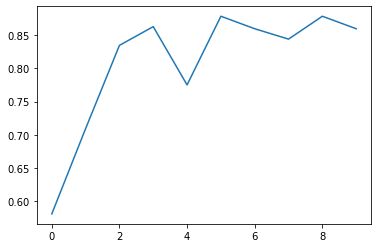

In [18]:
dfs = analysis.trial_dataframes
print([d.mean_accuracy.plot() for d in dfs.values()])

# Get a dataframe for analyzing trial results.
df = analysis.results_df
df

### 2.2 Early Stopping with ASHA by adding scheduler

In [24]:
analysis = tune.run(
    train_mnist,
    num_samples=20,
    scheduler=ASHAScheduler(metric="mean_accuracy", mode="max"),
    config=search_space,
     verbose = 1)

(pid=383) == Status ==
(pid=383) Memory usage on this node: 1.8/15.6 GiB
(pid=383) Using AsyncHyperBand: num_stopped=0
(pid=383) Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
(pid=383) Resources requested: 0/16 CPUs, 0/0 GPUs, 0.0/11.2 GiB heap, 0.0/5.09 GiB objects (0.0/3.0 example-resource-a, 0.0/3.0 example-resource-b)
(pid=383) Result logdir: /home/ray/ray_results/train_mnist_2021-08-23_07-28-01
(pid=383) Number of trials: 17/20 (17 PENDING)
(pid=383) 
(pid=383) 
(pid=383) == Status ==
(pid=383) Memory usage on this node: 2.6/15.6 GiB
(pid=383) Using AsyncHyperBand: num_stopped=8
(pid=383) Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.11562499999999999 | Iter 1.000: 0.15390625
(pid=383) Resources requested: 11.0/16 CPUs, 0/0 GPUs, 0.0/11.2 GiB heap, 0.0/5.09 GiB objects (0.0/3.0 example-resource-a, 0.0/3.0 example-resource-b)
(pid=383) Result logdir: /home/ray/ray_results/train_mnist_2021-08-23_07-28-01
(pid=383) Number of tri

(pid=383) 2021-08-23 07:28:09,339	INFO tune.py:550 -- Total run time: 8.21 seconds (8.03 seconds for the tuning loop).


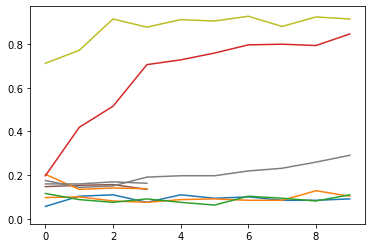

In [25]:
# Obtain a trial dataframe from all run trials of this `tune.run` call.
dfs = analysis.trial_dataframes

# Plot by epoch
ax = None  # This plots everything on the same plot
for d in dfs.values():
    ax = d.mean_accuracy.plot(ax=ax, legend=False)

In [21]:
stop_ray_cluster(ray_cluster)

Deleting ray-worker-b629b041-9f6c-49c3-bb7c-4f338b0d49b9
Deleting ray-worker-cee4eb89-6773-4c15-9e80-35b79ae5a181
